In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
# For handling Excel files
import openpyxl
# For progress bars
from tqdm.notebook import tqdm
# Setting plot style
sns.set(style="whitegrid")
%matplotlib inline
import glob
import shutil
import random
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [1]:
import os
import shutil
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Define the path to the original dataset directory
original_dataset_dir = '/kaggle/input/moderate-imbalance-leukemia/Moderate imbalance'

# Define paths for the train and test sets
train_dir = {
    'all': os.path.join(original_dataset_dir, 'Train', 'all'),
    'hem': os.path.join(original_dataset_dir, 'Train', 'hem')
}
test_dir = {
    'all': os.path.join(original_dataset_dir, 'Test', 'all'),
    'hem': os.path.join(original_dataset_dir, 'Test', 'hem')
}

# Define the working directory to copy the dataset
working_dir = '/kaggle/working/imbalance-leukemia/High_imbalance'

# Create the target directories in the working directory if they don't exist
os.makedirs(os.path.join(working_dir, 'Train', 'all'), exist_ok=True)
os.makedirs(os.path.join(working_dir, 'Train', 'hem'), exist_ok=True)
os.makedirs(os.path.join(working_dir, 'Test', 'all'), exist_ok=True)
os.makedirs(os.path.join(working_dir, 'Test', 'hem'), exist_ok=True)

# Copy data from the original dataset to the working directory
try:
    shutil.copytree(train_dir['all'], os.path.join(working_dir, 'Train', 'all'), dirs_exist_ok=True)
    shutil.copytree(train_dir['hem'], os.path.join(working_dir, 'Train', 'hem'), dirs_exist_ok=True)
    shutil.copytree(test_dir['all'], os.path.join(working_dir, 'Test', 'all'), dirs_exist_ok=True)
    shutil.copytree(test_dir['hem'], os.path.join(working_dir, 'Test', 'hem'), dirs_exist_ok=True)
    print("Files copied successfully!")
except Exception as e:
    print(f"Error during copying: {e}")

# Define the LeukemiaDataset class
class LeukemiaDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        
        # Iterate over all subdirectories (all, hem) and get the images
        for label, sub_dir in enumerate(['all', 'hem']):
            class_dir = os.path.join(data_dir, sub_dir)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_files.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.labels[idx]
        
        # Load image and convert to RGB
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the paths for the new train and test sets in the working directory
train_dir_working = {
    'all': os.path.join(working_dir, 'Train', 'all'),
    'hem': os.path.join(working_dir, 'Train', 'hem')
}
test_dir_working = {
    'all': os.path.join(working_dir, 'Test', 'all'),
    'hem': os.path.join(working_dir, 'Test', 'hem')
}

# Load train and test datasets from the working directory
train_dataset = LeukemiaDataset(data_dir=os.path.join(working_dir, 'Train'), transform=train_transform)
test_dataset = LeukemiaDataset(data_dir=os.path.join(working_dir, 'Test'), transform=val_test_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to count the number of files in each directory
def count_files_in_dir(directory):
    file_count = 0
    for sub_dir in ['all', 'hem']:  # Check both 'all' and 'hem' directories
        class_dir = os.path.join(directory, sub_dir)
        if os.path.exists(class_dir):
            file_count += len(os.listdir(class_dir))  # Count files in the sub-directory
    return file_count

# Count files in the training and testing datasets
train_file_count = count_files_in_dir(os.path.join(working_dir, 'Train'))
test_file_count = count_files_in_dir(os.path.join(working_dir, 'Test'))

# Print the counts
print(f"Training set - Total files: {train_file_count}")
print(f"Testing set - Total files: {test_file_count}")


Files copied successfully!
Training set - Total files: 110
Testing set - Total files: 60


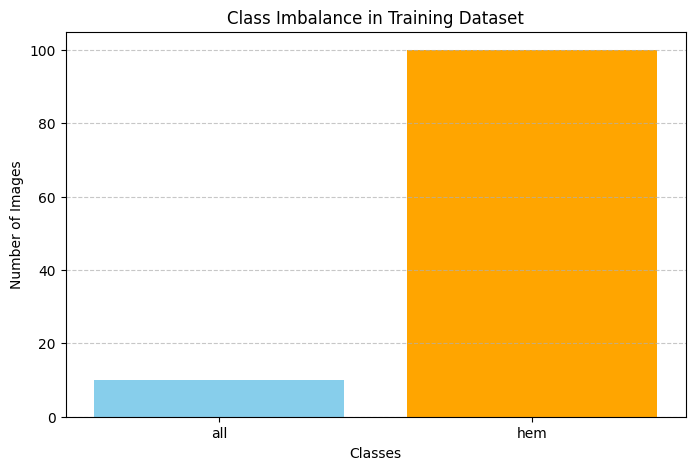

In [2]:
import matplotlib.pyplot as plt

# Function to count the number of images per class
def count_class_distribution(directory):
    class_counts = {}
    for class_name in ['all', 'hem']:
        class_dir = os.path.join(directory, class_name)
        if os.path.exists(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
        else:
            class_counts[class_name] = 0
    return class_counts

# Count class distribution for training set
train_class_counts = count_class_distribution(os.path.join(working_dir, 'Train'))

# Plotting the class distributions for training set
def plot_train_class_distribution(train_counts):
    labels = list(train_counts.keys())
    train_values = list(train_counts.values())

    plt.figure(figsize=(8, 5))
    plt.bar(labels, train_values, color=['skyblue', 'orange'])
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Class Imbalance in Training Dataset')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot the graph
plot_train_class_distribution(train_class_counts)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import timm

In [5]:
class GhostNet(nn.Module):
    def __init__(self, num_classes):
        super(GhostNet, self).__init__()
        # Initialize GhostNet without pre-trained weights
        self.base_model = timm.create_model('ghostnet_100', pretrained=False, num_classes=num_classes)
        self.features = self.base_model.forward_features  # Feature extraction part
        
        self.pool = nn.AdaptiveAvgPool2d(1)  # Global average pooling
        self.fc = nn.Linear(960, num_classes)  # Final classifier (960 channels)

    def forward(self, x):
        x = self.features(x)  # Feature extraction
        x = self.pool(x)  # Global average pooling
        x = torch.flatten(x, 1)  # Flatten for classification
        x = self.fc(x)  # Final classification
        return x

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 2

model = GhostNet(num_classes=num_classes) 

model.to(device)
print(model)

GhostNet(
  (base_model): GhostNet(
    (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): GhostBottleneck(
          (ghost1): GhostModule(
            (primary_conv): Sequential(
              (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (cheap_operation): Sequential(
              (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (ghost2): GhostModule(
            (primary_co

In [16]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [18]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=50):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(dataloader, desc=phase.capitalize()):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        print()
    
    print(f'Best Validation Acc: {best_acc:.4f}')
    
    model.load_state_dict(best_model_wts)
    return model, history


In [20]:
from tqdm import tqdm  # Import tqdm for progress bars

# Train the model
num_epochs = 100
model, history = train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs=num_epochs)


Epoch 1/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


Train Loss: 0.0803 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]


Val Loss: 0.9120 Acc: 0.5833

Epoch 2/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


Train Loss: 0.0840 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00,  9.88it/s]


Val Loss: 0.9078 Acc: 0.6167

Epoch 3/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Train Loss: 0.1179 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]


Val Loss: 0.9266 Acc: 0.6000

Epoch 4/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


Train Loss: 0.1184 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


Val Loss: 0.8685 Acc: 0.6667

Epoch 5/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Train Loss: 0.1762 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  9.97it/s]


Val Loss: 0.8842 Acc: 0.6500

Epoch 6/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


Train Loss: 0.1028 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


Val Loss: 0.8836 Acc: 0.6500

Epoch 7/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Train Loss: 0.1251 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]


Val Loss: 0.9111 Acc: 0.6000

Epoch 8/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Train Loss: 0.0835 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]


Val Loss: 0.9008 Acc: 0.5833

Epoch 9/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


Train Loss: 0.1265 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]


Val Loss: 0.8873 Acc: 0.6167

Epoch 10/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Train Loss: 0.1014 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]


Val Loss: 0.8958 Acc: 0.6333

Epoch 11/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Train Loss: 0.1059 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.77it/s]


Val Loss: 0.8610 Acc: 0.6500

Epoch 12/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Train Loss: 0.0615 Acc: 0.9818


Val: 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]


Val Loss: 0.8799 Acc: 0.6500

Epoch 13/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Train Loss: 0.1000 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]


Val Loss: 0.8812 Acc: 0.6500

Epoch 14/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]


Train Loss: 0.1345 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  9.87it/s]


Val Loss: 0.9078 Acc: 0.6167

Epoch 15/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


Train Loss: 0.1548 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]


Val Loss: 0.8616 Acc: 0.6500

Epoch 16/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Train Loss: 0.0835 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.44it/s]


Val Loss: 0.8861 Acc: 0.6167

Epoch 17/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Train Loss: 0.1230 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


Val Loss: 0.9052 Acc: 0.5833

Epoch 18/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


Train Loss: 0.1021 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


Val Loss: 0.8821 Acc: 0.6000

Epoch 19/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


Train Loss: 0.0996 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.55it/s]


Val Loss: 0.8878 Acc: 0.5833

Epoch 20/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


Train Loss: 0.0844 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


Val Loss: 0.9028 Acc: 0.5833

Epoch 21/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Train Loss: 0.0919 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.12it/s]

Val Loss: 0.8993 Acc: 0.6167



Epoch 22/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


Train Loss: 0.1102 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


Val Loss: 0.8910 Acc: 0.6000

Epoch 23/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


Train Loss: 0.1210 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00, 10.77it/s]


Val Loss: 0.8498 Acc: 0.6500

Epoch 24/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


Train Loss: 0.0872 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.77it/s]


Val Loss: 0.8510 Acc: 0.6500

Epoch 25/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


Train Loss: 0.1166 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.64it/s]


Val Loss: 0.8853 Acc: 0.6333

Epoch 26/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Train Loss: 0.0959 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]


Val Loss: 0.8855 Acc: 0.6500

Epoch 27/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


Train Loss: 0.1040 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


Val Loss: 0.9391 Acc: 0.6000

Epoch 28/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


Train Loss: 0.0743 Acc: 0.9818


Val: 100%|██████████| 2/2 [00:00<00:00, 10.80it/s]


Val Loss: 0.8993 Acc: 0.6167

Epoch 29/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


Train Loss: 0.1034 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


Val Loss: 0.9317 Acc: 0.6000

Epoch 30/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Train Loss: 0.1353 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]


Val Loss: 0.9265 Acc: 0.6000

Epoch 31/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Train Loss: 0.0732 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


Val Loss: 0.9090 Acc: 0.5833

Epoch 32/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Train Loss: 0.0742 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


Val Loss: 0.9406 Acc: 0.6167

Epoch 33/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Train Loss: 0.0764 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]


Val Loss: 0.9360 Acc: 0.5833

Epoch 34/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Train Loss: 0.1088 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00,  9.28it/s]


Val Loss: 0.9384 Acc: 0.5667

Epoch 35/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


Train Loss: 0.0686 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]

Val Loss: 0.8714 Acc: 0.6500



Epoch 36/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


Train Loss: 0.1063 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.72it/s]


Val Loss: 0.8873 Acc: 0.6000

Epoch 37/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]


Train Loss: 0.1326 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]


Val Loss: 0.9752 Acc: 0.5833

Epoch 38/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


Train Loss: 0.1275 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00, 10.79it/s]


Val Loss: 0.9620 Acc: 0.5833

Epoch 39/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Train Loss: 0.0981 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.70it/s]


Val Loss: 0.9308 Acc: 0.5833

Epoch 40/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Train Loss: 0.0965 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


Val Loss: 0.9545 Acc: 0.5833

Epoch 41/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Train Loss: 0.0707 Acc: 0.9818


Val: 100%|██████████| 2/2 [00:00<00:00, 10.57it/s]


Val Loss: 0.9328 Acc: 0.6000

Epoch 42/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Train Loss: 0.1120 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


Val Loss: 0.8877 Acc: 0.6167

Epoch 43/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


Train Loss: 0.1273 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]


Val Loss: 0.8937 Acc: 0.6000

Epoch 44/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Train Loss: 0.0907 Acc: 0.9818


Val: 100%|██████████| 2/2 [00:00<00:00, 10.47it/s]


Val Loss: 0.9322 Acc: 0.6167

Epoch 45/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


Train Loss: 0.0723 Acc: 0.9818


Val: 100%|██████████| 2/2 [00:00<00:00, 10.87it/s]


Val Loss: 0.9055 Acc: 0.6167

Epoch 46/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Train Loss: 0.0988 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]


Val Loss: 0.9218 Acc: 0.6167

Epoch 47/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Train Loss: 0.1297 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.12it/s]


Val Loss: 0.8716 Acc: 0.6500

Epoch 48/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


Train Loss: 0.1055 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.77it/s]


Val Loss: 0.8421 Acc: 0.6500

Epoch 49/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


Train Loss: 0.1595 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


Val Loss: 0.8860 Acc: 0.6167

Epoch 50/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Train Loss: 0.1339 Acc: 0.9182


Val: 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]


Val Loss: 0.9526 Acc: 0.5833

Epoch 51/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Train Loss: 0.0890 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00,  9.84it/s]


Val Loss: 0.9471 Acc: 0.5833

Epoch 52/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


Train Loss: 0.1092 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00, 10.47it/s]


Val Loss: 0.9336 Acc: 0.5667

Epoch 53/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


Train Loss: 0.0915 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.87it/s]


Val Loss: 0.9145 Acc: 0.5833

Epoch 54/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Train Loss: 0.1145 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]


Val Loss: 0.9574 Acc: 0.5833

Epoch 55/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


Train Loss: 0.1151 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.12it/s]


Val Loss: 0.9147 Acc: 0.5667

Epoch 56/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Train Loss: 0.0888 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.03it/s]


Val Loss: 0.8822 Acc: 0.6167

Epoch 57/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


Train Loss: 0.0934 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


Val Loss: 0.8991 Acc: 0.5833

Epoch 58/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Train Loss: 0.1034 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.64it/s]


Val Loss: 0.9089 Acc: 0.6000

Epoch 59/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Train Loss: 0.0936 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.83it/s]


Val Loss: 0.8953 Acc: 0.6167

Epoch 60/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


Train Loss: 0.0779 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00,  8.20it/s]


Val Loss: 0.9263 Acc: 0.5833

Epoch 61/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]


Train Loss: 0.1021 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


Val Loss: 0.8745 Acc: 0.6667

Epoch 62/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


Train Loss: 0.0967 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]


Val Loss: 0.8819 Acc: 0.6500

Epoch 63/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Train Loss: 0.1007 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


Val Loss: 0.8788 Acc: 0.6333

Epoch 64/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


Train Loss: 0.0743 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]


Val Loss: 0.9123 Acc: 0.6167

Epoch 65/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


Train Loss: 0.1156 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  9.30it/s]


Val Loss: 0.8627 Acc: 0.6500

Epoch 66/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Train Loss: 0.1041 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.86it/s]


Val Loss: 0.8890 Acc: 0.6333

Epoch 67/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Train Loss: 0.1058 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00, 10.61it/s]


Val Loss: 0.8751 Acc: 0.6500

Epoch 68/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Train Loss: 0.0847 Acc: 0.9818


Val: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


Val Loss: 0.8644 Acc: 0.6667

Epoch 69/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


Train Loss: 0.1239 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.49it/s]


Val Loss: 0.8825 Acc: 0.6500

Epoch 70/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Train Loss: 0.0972 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]


Val Loss: 0.8868 Acc: 0.6333

Epoch 71/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


Train Loss: 0.0762 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00,  9.99it/s]


Val Loss: 0.8726 Acc: 0.6333

Epoch 72/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


Train Loss: 0.1084 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]


Val Loss: 0.9469 Acc: 0.6000

Epoch 73/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Train Loss: 0.1229 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]


Val Loss: 0.9644 Acc: 0.6000

Epoch 74/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Train Loss: 0.0933 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


Val Loss: 0.9115 Acc: 0.6167

Epoch 75/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Train Loss: 0.1004 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.69it/s]


Val Loss: 0.8957 Acc: 0.6500

Epoch 76/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Train Loss: 0.1132 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]


Val Loss: 0.8717 Acc: 0.6333

Epoch 77/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


Train Loss: 0.1117 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00,  9.77it/s]


Val Loss: 0.8461 Acc: 0.6500

Epoch 78/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


Train Loss: 0.1083 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]


Val Loss: 0.8867 Acc: 0.5833

Epoch 79/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


Train Loss: 0.1349 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  9.82it/s]


Val Loss: 0.9068 Acc: 0.5833

Epoch 80/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Train Loss: 0.1104 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.71it/s]


Val Loss: 0.9463 Acc: 0.5833

Epoch 81/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


Train Loss: 0.1338 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00, 10.76it/s]


Val Loss: 0.9221 Acc: 0.5833

Epoch 82/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Train Loss: 0.1120 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00, 10.56it/s]


Val Loss: 0.9249 Acc: 0.5667

Epoch 83/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


Train Loss: 0.0966 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00,  7.74it/s]


Val Loss: 0.8717 Acc: 0.6500

Epoch 84/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Train Loss: 0.0910 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.69it/s]


Val Loss: 0.9674 Acc: 0.5833

Epoch 85/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Train Loss: 0.1033 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.74it/s]


Val Loss: 0.9418 Acc: 0.6000

Epoch 86/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


Train Loss: 0.0931 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.61it/s]


Val Loss: 0.9418 Acc: 0.6000

Epoch 87/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


Train Loss: 0.1153 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.68it/s]


Val Loss: 0.9770 Acc: 0.5833

Epoch 88/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Train Loss: 0.1024 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.51it/s]


Val Loss: 0.9311 Acc: 0.5833

Epoch 89/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


Train Loss: 0.0668 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.80it/s]


Val Loss: 0.8932 Acc: 0.6167

Epoch 90/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Train Loss: 0.0881 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.79it/s]


Val Loss: 0.9047 Acc: 0.6333

Epoch 91/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


Train Loss: 0.1192 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.72it/s]


Val Loss: 0.8966 Acc: 0.6500

Epoch 92/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Train Loss: 0.0924 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


Val Loss: 0.8895 Acc: 0.6500

Epoch 93/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


Train Loss: 0.1010 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


Val Loss: 0.8772 Acc: 0.6500

Epoch 94/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


Train Loss: 0.1129 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.87it/s]


Val Loss: 0.8988 Acc: 0.6500

Epoch 95/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Train Loss: 0.0790 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.58it/s]


Val Loss: 0.9445 Acc: 0.6167

Epoch 96/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Train Loss: 0.1158 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


Val Loss: 0.9165 Acc: 0.6333

Epoch 97/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Train Loss: 0.1277 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.20it/s]

Val Loss: 0.9304 Acc: 0.5833



Epoch 98/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


Train Loss: 0.0938 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.47it/s]


Val Loss: 0.9153 Acc: 0.5833

Epoch 99/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Train Loss: 0.0890 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00,  9.78it/s]


Val Loss: 0.9002 Acc: 0.5833

Epoch 100/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Train Loss: 0.0745 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.47it/s]


Val Loss: 0.8863 Acc: 0.6333

Best Validation Acc: 0.6667


Testing: 100%|██████████| 2/2 [00:00<00:00,  7.32it/s]


Classification Report:
              precision    recall  f1-score   support

         All       0.83      0.33      0.48        30
         Hem       0.58      0.93      0.72        30

    accuracy                           0.63        60
   macro avg       0.71      0.63      0.60        60
weighted avg       0.71      0.63      0.60        60



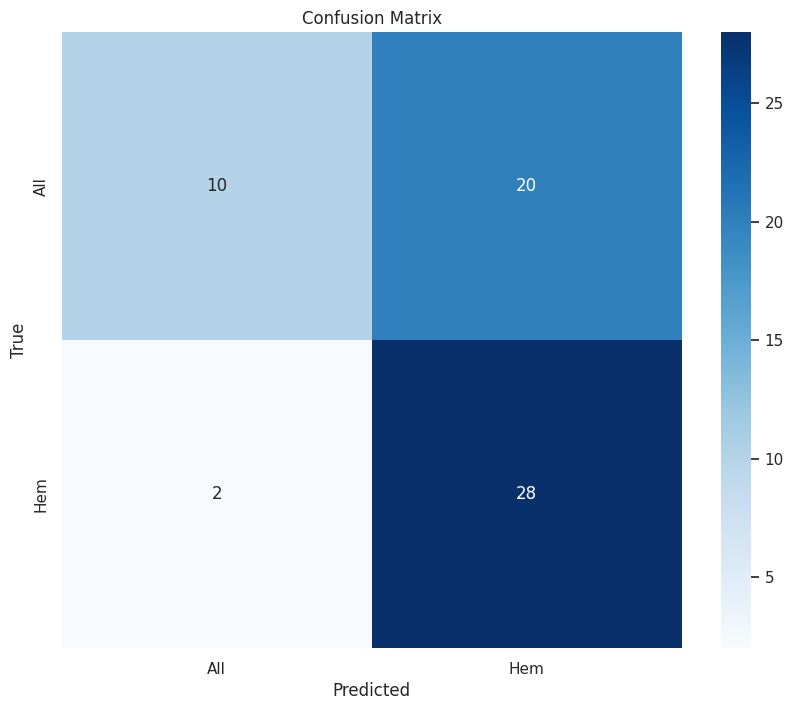

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model on the test set
evaluate_model(model, test_loader, classes=['All', 'Hem'])

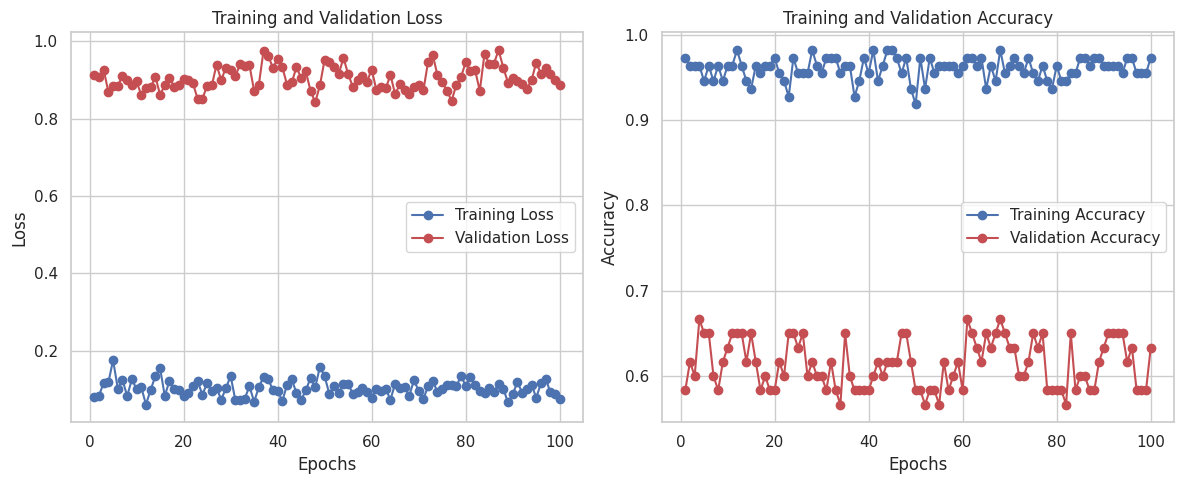

In [23]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)


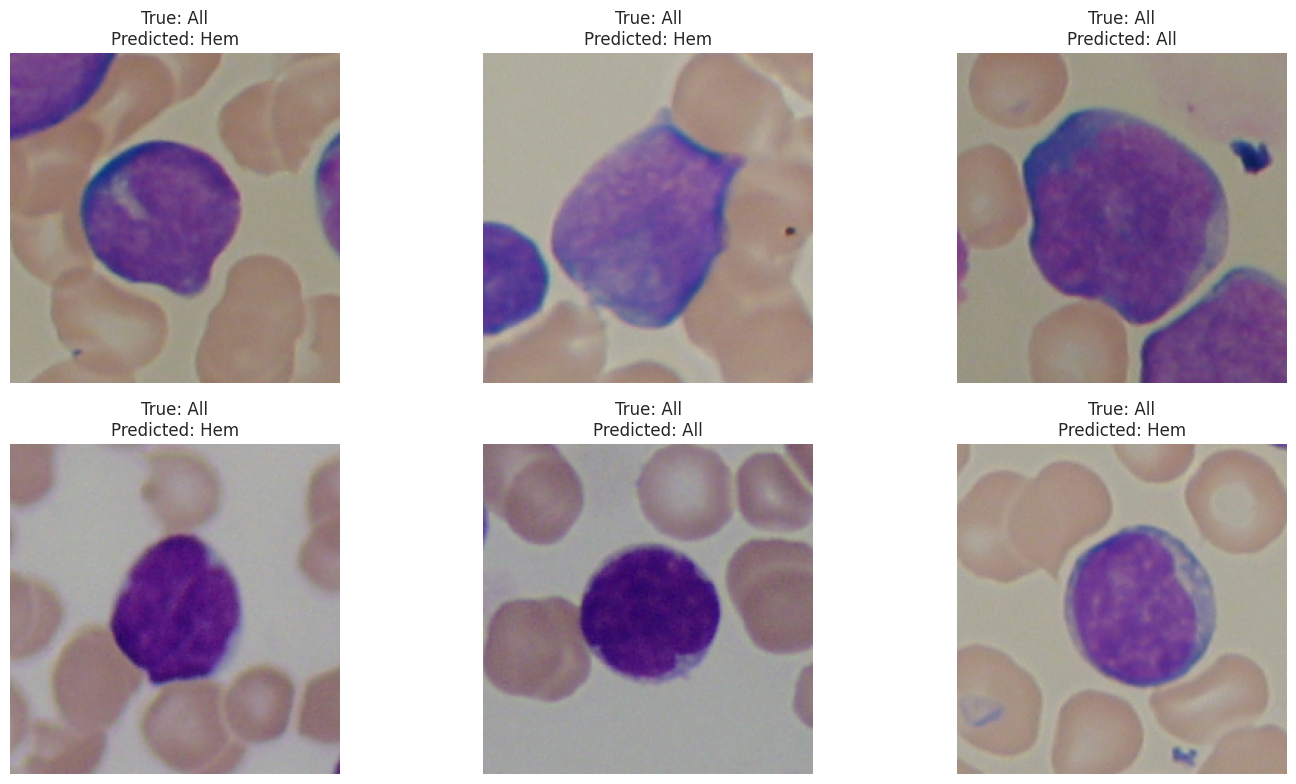

In [24]:
import numpy as np
def visualize_predictions(model, dataloader, classes, num_images=6):
    model.eval()
    images, labels = next(iter(dataloader))
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        img = images[i].transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                      np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(f"True: {classes[labels[i]]}\nPredicted: {classes[preds[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample predictions
visualize_predictions(model, test_loader, classes=['All', 'Hem'], num_images=6)
